In [ ]:
!nvidia-smi

Mon Apr 24 07:48:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    29W /  70W |   1575MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

import random

In [ ]:
# check if cuda is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
# We transform them to tensors
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# torchvision.datasets.MNIST outputs a set of PIL images
# Load and transform data
MNIST_train = torchvision.datasets.MNIST('/tmp', train=True, download=True, transform=train_transforms)
MNIST_trainset, MNIST_valset = torch.utils.data.random_split(MNIST_train, [55000, 5000])
MNIST_testset = torchvision.datasets.MNIST('/tmp', train=False, download=True, transform=test_transforms)   

In [ ]:
x = torch.arange(0,5)
print(x)
torch.nn.functional.one_hot(x)

tensor([0, 1, 2, 3, 4])


tensor([[1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1]])

In [ ]:
class RandomMNISTDataset(Dataset):
  def __init__(self, MNISTDataset):
    self.MNISTDataset = MNISTDataset

  def __getitem__(self, index):
    image = self.MNISTDataset[index][0]
    label = self.MNISTDataset[index][1]
    label_one_hot = F.one_hot(torch.tensor(label), 10)

    return image, label, label_one_hot

  def __len__(self):
    return len(self.MNISTDataset)

In [ ]:
train_dataset = RandomMNISTDataset(MNIST_trainset)
val_dataset = RandomMNISTDataset(MNIST_valset)
test_dataset = RandomMNISTDataset(MNIST_testset)

In [ ]:
print(f'The number of images in train dataset - {len(train_dataset)}')
print(f'The number of images in val dataset - {len(val_dataset)}')

print(f'The number of images in test dataset - {len(test_dataset)}')

The number of images in train dataset - 55000
The number of images in val dataset - 5000
The number of images in test dataset - 10000


In [ ]:
train_loader = DataLoader(train_dataset,batch_size=128,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=128)
test_loader = DataLoader(test_dataset,batch_size=128)

In [ ]:
dataiter = iter(train_loader)
images, labels, label_one_hot = next(dataiter)

print('Images: ', images.shape)
print('Labels: ', labels.shape)
print(f'label_one_hot : {label_one_hot.shape}')

print('\nLabels: ', labels[0:3])
print(f'label_one_hot : {label_one_hot[0:3]}')

Images:  torch.Size([128, 1, 28, 28])
Labels:  torch.Size([128])
label_one_hot : torch.Size([128, 10])

Labels:  tensor([4, 2, 7])
label_one_hot : tensor([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)       #Input: 28*28*1    Output:28 * 28 * 32    GRF:3 * 3  (GRF - Global Receptive Field)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)      #Input: 28*28*32   Output:28 * 28 * 64    GRF:5 * 5
        self.pool1 = nn.MaxPool2d(2, 2)                   #Input: 28*28*64   Output:14 * 14 * 64    GRF:10*10 (for now we are considering that with max pooling, receptive field doubles - but this is not entirely correct)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)     #Input: 14*14*64   Output:14 * 14 * 128   GRF:12*12
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)    #Input: 14*14*128  Output:14 * 14 * 256   GRF:14*14
        self.pool2 = nn.MaxPool2d(2, 2)                   #Input: 14*14*256  Output: 7 * 7 * 256    GRF:28*28
        self.conv5 = nn.Conv2d(256, 512, 3)               #Input: 7*7*256    Output: 5 * 5 * 12     GRF:30*30
        self.conv6 = nn.Conv2d(512, 1024, 3)              #Input: 5*5*12     Output: 3 * 3 * 1024   GRF:32*32
        self.conv7 = nn.Conv2d(1024, 10, 3)               #Input: 3*3*1024   Output: 1 * 1 * 10     GRF:34*34


        self.fc1 = nn.Linear(10+10, 128)                  #Concatenate two inputs 

    def forward(self, image, label_one_hot):
        #The first convolutional layer self.conv1 has a convolutional operation on input tensor x, followed by a relu activation operation 
        #whcih is then passed to second convolution operation self.conv2 followed by a relu whose output is then passed to a max pooling 
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(image)))))

        #The output of the max pool operation is passed to another two convolution and relu activation operation followed by max pooling. 
        #The relu() and the max_pool2d() calls are just pure operations. Neither of these have weights  
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))

        #The output of the max pool operation from 4th convolution is passed to another two sets of convolution and relu activation operation
        x = F.relu(self.conv6(F.relu(self.conv5(x))))

        # The output from 6th convolution is then passed to a linear layer
        x = self.conv7(x)  
        
        #The flatten's all of the tensor's elements into a single dimension.
        x = x.view(-1, 10)
        
        #concatenate second input to the output from above convolution
        x1 = torch.cat((x, label_one_hot), dim=1)
        
        # Further train the network on Dense Layer
        x1 = F.relu(self.fc1(x1)) 

        # Inside the network we usually use relu() as our non-linear activation function, but for the output layer, 
        # we use Softmax function for predicting category with maximum probability.         
        #The softmax function returns a positive probability for each of the prediction classes, and the values sum to 1.

        return F.log_softmax(x, dim = 1)

In [ ]:
# move the model to the specified device
model = Net().to(device)
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(1024, 10, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=20, out_features=128, bias=True)
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 6,382,474 trainable parameters


In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    # set the model in training model
    model.train()

    epoch_loss = 0

    # run for all the data in train_loader
    for batch_idx, (data, target, label_one_hot) in enumerate(train_loader):

        # fetch the data and the target values
        target = target.type(torch.LongTensor)
        label_one_hot = label_one_hot.type(torch.LongTensor)

        # move the data to device
        data, target, label_one_hot = data.to(device), target.to(device), label_one_hot.to(device)

        # zero out the gradients
        optimizer.zero_grad()

        # forward pass the model with the data
        output = model(data,label_one_hot)

        # compute the loss occured
        loss = F.nll_loss(output, target)

        epoch_loss += loss.item()

        # compute the backward gradients
        loss.backward()

        # update the optimizer params
        optimizer.step()
    print('Train set: Average loss: {:.4f}'.format(loss.item()))

    train_loss = epoch_loss / len(train_loader)
    return train_loss

In [ ]:
def test(model, device, test_loader,test_type='Val'):
    # set the model in evaluation model
    model.eval()

    # set the loss to zero
    test_loss = 0
    
    # the number of correct classifications
    correct_mnist = 0
    correct_addition = 0

    # turn off gradients during the testing
    with torch.no_grad():
        for (data, target, label_one_hot) in test_loader:

            # move the data to device
            target = target.type(torch.LongTensor)
            label_one_hot = label_one_hot.type(torch.LongTensor)
            data, target, label_one_hot = data.to(device), target.to(device), label_one_hot.to(device)

            # forward pass the model and get the output
            output = model(data,label_one_hot)

            # accumulate the loss from both the network outputs
            test_loss += F.nll_loss(output, target, reduction='sum').item() 

            # get the index of max log-probability
            mnist_pred = output.argmax(dim=1, keepdim=True)

    # test loss divided by the total number of items in test dataset
    test_loss /= len(test_loader.dataset)
    print(f'{test_type} set: Average loss: {test_loss:.3f}')

    return test_loss

In [ ]:
# move the model to the specified device
model = Net().to(device)

# use Stochastic Gradient Descent as the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.7)

# set the number of epochs to train for
num_epoch = 2

train_loss_values = []
valid_loss_values = []

# run it for epoch number of times
for epoch in range(1, num_epoch+1):
    print('\nEpoch {} : '.format(epoch))
    # train the model
    train_loss = train(model, device, train_loader, optimizer, epoch)
    valid_loss = test(model, device, val_loader)
    # test the model

    train_loss_values.append(train_loss)
    valid_loss_values.append(valid_loss)


Epoch 1 : 
Train set: Average loss: 0.2246
Val set: Average loss: 0.143

Epoch 2 : 
Train set: Average loss: 0.0382
Val set: Average loss: 0.076


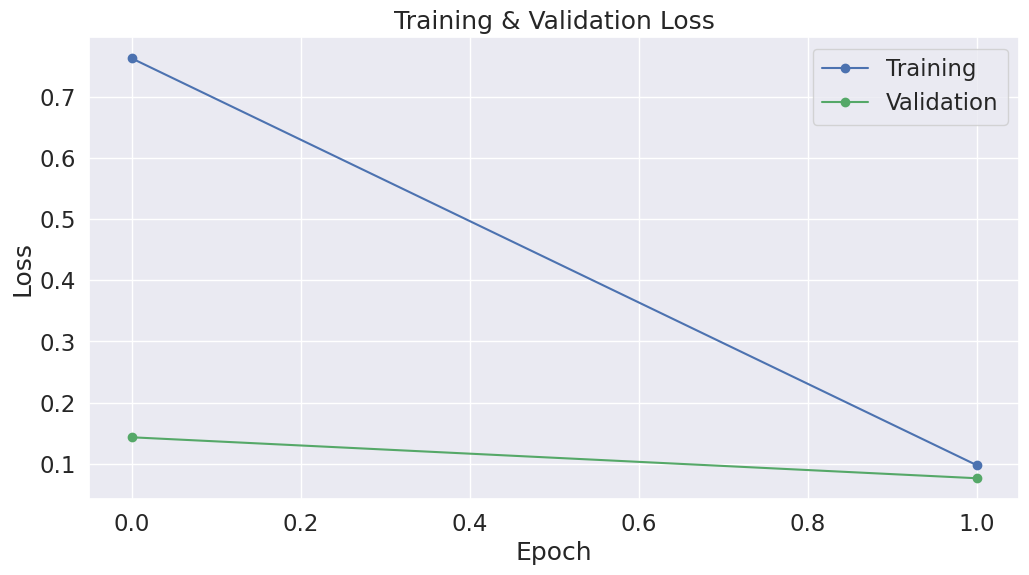

In [ ]:
import matplotlib.pyplot as plt

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(np.array(train_loss_values), 'b-o', label="Training")
plt.plot(np.array(valid_loss_values), 'g-o', label="Validation")


# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
test_loss = test(model, device, test_loader,'Test')

Test set: Average loss: 0.072


In [ ]:
def prediction(image,rnum):

    rnum_ohe = torch.zeros(11).long()
    rnum_ohe[rnum] = 1
    rnum_ohe = rnum_ohe[:-1]

    output_1 = model(image.unsqueeze(dim=1).to(device),rnum_ohe.reshape(-1,10).to(device))

    mnist_pred = output_1.argmax(dim=1, keepdim=True)

    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(3, 3, 1)
    ax.axis('off')
    ax.imshow(image.cpu().numpy().squeeze())
    ax.set_title(f'Random Number Generated : {rnum} \n'
                 f'Mnist Prediction: {mnist_pred.item()}')
    return mnist_pred

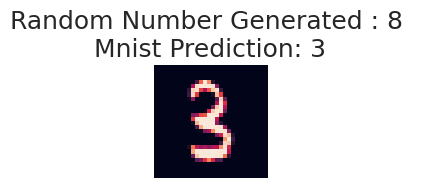

In [ ]:
image,_,_ = test_dataset[random.randint(1,10000)]
rnum=random.randint(0,9)
mnist_pred=prediction(image,rnum)

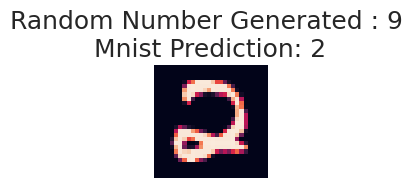

In [ ]:
image,_,_ = test_dataset[random.randint(1,10000)]
rnum=random.randint(0,9)
mnist_pred =prediction(image,rnum)